In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = '../../data/'

In [5]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 전처리

In [6]:
# 가장 nan 값이 많은 건 날씨 관련 정보임.
# 따라서 단순히 mean값으로 채우면 안됨.
# mean값으로 채울거면 안 쓰는 것이 나음.
# 하지만 U_
# df.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN'],axis=1,inplace=True)
# df_test.drop(['U_WIND','V_WIND','AIR_TEMPERATURE','BN'],axis=1,inplace=True)

In [7]:
df['ATA'] = pd.to_datetime(df['ATA'])
df_test['ATA'] = pd.to_datetime(df_test['ATA'])

In [8]:
df['DATE'] = df['ATA'].apply(lambda x: x.date())
df_test['DATE'] = df_test['ATA'].apply(lambda x: x.date())

In [9]:
df['ATA'] = pd.to_datetime(df['ATA'])
df_test['ATA'] = pd.to_datetime(df_test['ATA'])

for df_ in [df, df_test]:
    df_['year'] = df_['ATA'].dt.year
    df_['month'] = df_['ATA'].dt.month
    df_['day'] = df_['ATA'].dt.day
    df_['hour'] = df_['ATA'].dt.hour
    df_['minute'] = df_['ATA'].dt.minute
    df_['weekday'] = df_['ATA'].dt.weekday
# datetime 컬럼 제거
df.drop(columns='ATA', inplace=True)
df_test.drop(columns='ATA', inplace=True)

In [10]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

In [11]:
for columns in categorical_features:
    le = LabelEncoder()
    df[columns] = le.fit_transform(df[columns])
    
    for label in df_test[columns].unique(): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    df_test[columns]= le.transform(df_test[columns]) 

In [12]:
df['SAMPLE_ID'] = df.index
df_test['SAMPLE_ID'] = df_test.index

In [13]:
df['COS_ATA_LT'] = np.cos(2*np.pi*(df.ATA_LT/24))
df['SIN_ATA_LT'] = np.sin(2*np.pi*(df.ATA_LT/24))

df_test['COS_ATA_LT'] = np.cos(2*np.pi*(df_test.ATA_LT/24))
df_test['SIN_ATA_LT'] = np.sin(2*np.pi*(df_test.ATA_LT/24))

In [14]:
# 결측치 처리
df = df[['CI_HOUR','SAMPLE_ID', 'month', 'day', 'BN','COS_ATA_LT','SIN_ATA_LT','weekday']]
df_test = df_test[['SAMPLE_ID', 'month', 'day', 'BN','COS_ATA_LT','SIN_ATA_LT','weekday']]
df.dropna(inplace=True)
df_test.dropna(inplace=True)

C:\Users\ineeji\AppData\Local\Temp\ipykernel_41196\1725919897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(inplace=True)


In [15]:
df.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

### modeling

In [16]:
import lightgbm as lgb

In [17]:
df_train, df_val = train_test_split(df,test_size=0.2,random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)

In [18]:
x_train = df_train.drop(['CI_HOUR','SAMPLE_ID'],axis=1)
y_train = df_train['CI_HOUR']

x_val = df_val.drop(['CI_HOUR','SAMPLE_ID'],axis=1)
y_val = df_val['CI_HOUR']

#x_train = x_train[['WTI', 'DUBAI', 'BRENT','OIL', 'month', 'day', 'BDI_ADJ']]
#x_val = x_val[['WTI', 'DUBAI', 'BRENT','OIL', 'month', 'day', 'BDI_ADJ']]

In [19]:
reg_model = lgb.LGBMRegressor(n_estimators=10000, verbose = 100)

reg_model.fit(x_train,y_train)

y_pred = reg_model.predict(x_val)
y_pred[y_pred<0]=0
mae = mean_absolute_error(y_val,y_pred)
print(mae)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.046469
[LightGBM] [Debug] init for col-wise cost 0.000040 seconds, init for row-wise cost 0.004202 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 182600, number of used features: 6
[LightGBM] [Info] Start training from score 65.548058
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000001500799EB80>
Traceback (most recent call last):
  File "c:\Users\ineeji\anaconda3\envs\v1\lib\site-packages\lightgbm\basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [

In [23]:
reg_model = lgb.LGBMRegressor(n_estimators=10000)

reg_model.fit(x_train,y_train)

y_pred = reg_model.predict(x_val)
y_pred[y_pred<0]=0
mae = mean_absolute_error(y_val,y_pred)
print(mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 171164, number of used features: 7
[LightGBM] [Info] Start training from score 65.468953
9.188347726142599


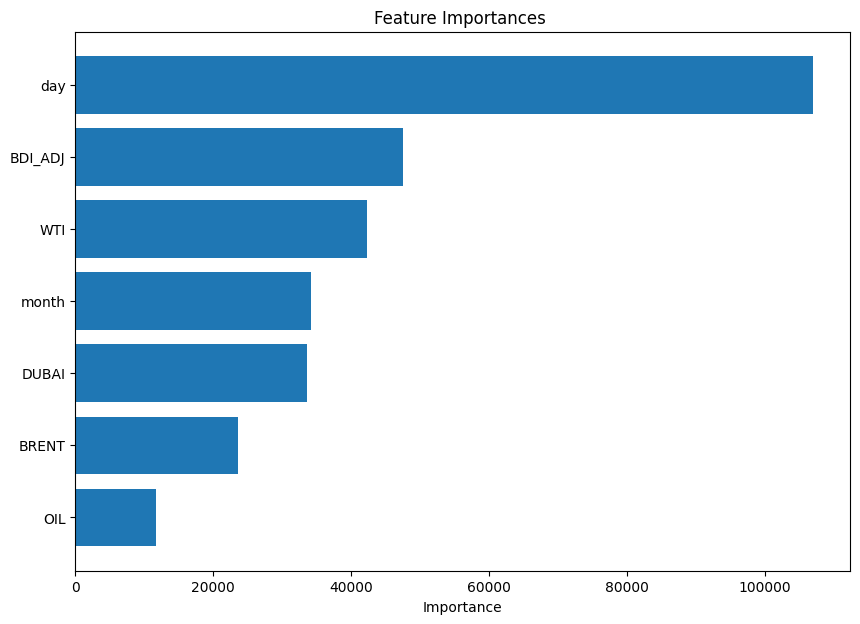

In [24]:
feature_importances = reg_model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, len(x_train.columns)))
plt.title(f"Feature Importances ")
plt.barh(range(x_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(x_train.shape[1]), x_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

In [25]:
df

,CI_HOUR,SAMPLE_ID,WTI,DUBAI,BRENT,OIL,month,day,BDI_ADJ,BN,COS_ATA_LT,SIN_ATA_LT,weekday
0,3.048333,0,40.96,42.01,43.16,126.13,10,15,1407.668330,2.730798,-1.000000,1.224647e-16,3
1,17.138611,1,59.34,67.53,64.55,191.42,9,17,2089.046774,4.289058,-0.866025,5.000000e-01,1
2,98.827500,2,56.94,65.30,66.39,188.63,2,23,603.193047,0.000000,-0.866025,-5.000000e-01,5
3,0.000000,3,41.11,43.02,43.15,127.28,9,18,1169.853455,4.693735,-0.258819,9.659258e-01,4
4,96.030556,4,88.11,90.45,93.65,272.21,8,13,1107.944894,2.345875,-0.866025,-5.000000e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213950,83.960833,367434,109.56,108.43,114.13,332.12,6,16,2067.433444,2.651752,0.866025,-5.000000e-01,3
213951,0.000000,367437,104.69,105.37,109.34,319.40,4,29,1955.103846,1.028558,-0.965926,2.588190e-01,4
213952,0.997500,367438,95.78,97.73,99.10,292.61,7,14,1601.291086,2.557156,-0.707107,-7.071068e-01,3
213953,0.000000,367439,47.02,49.75,50.08,146.85,12,22,1191.353331,3.055715,0.258819,-9.659258e-01,1


In [26]:
x_train = df[['WTI', 'DUBAI', 'BRENT','OIL', 'month', 'day', 'BDI_ADJ']]
x_test = df_test[['WTI', 'DUBAI', 'BRENT','OIL', 'month', 'day', 'BDI_ADJ']]

y_train = df['CI_HOUR']

In [29]:
lgbm = lgb.LGBMRegressor(n_estimators=30000)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(x_train), total=5, desc="Processing folds"):
    X_t, X_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    lgbm.fit(X_t, y_t)
    
    val_pred = lgbm.predict(X_val)
    scores.append(mean_absolute_error(y_val, val_pred))
    
    lgbm_pred = lgbm.predict(x_test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

final_predictions = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 171164, number of used features: 7
[LightGBM] [Info] Start training from score 65.468953


In [ ]:
final_predictions[final_predictions<0]=0

In [ ]:
submit = pd.read_csv('../../data/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('../../data/exp12.csv',index=False)